In [4]:
import numpy as np
import matplotlib.pyplot as plt
import filtering as flt

## Parameters

In [5]:
T = 10 # simulation time
dt = 0.01 # step size
t = np.arange(0,T,dt)
kappa_phi = 1 # inverse diffusion constant
phi_0 = 0 # initial mean
kappa_0 = 20 # initial certainty

# colors for plotting
col_PF = 'xkcd:green'
col_ADF = 'xkcd:blue'
col_vM = 'xkcd:orange'

## Preprocessing / Load data
Raw data can be generated by running `performance_scan_direct.py`, and can afterwards be found in `/data_raw`. This raw data needs to be preprocessed to be accessible to this script. Depending on the number of iterations, these files can be considerably large, which is why we only provide the preprocessed data here (and load it). We nevertheless provide the code for preprocessing for completeness.

In [8]:
# reliability levels for direct angular observations
kappa_z_array = np.array([0.01,0.03,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10])
timepoints = [0,2,4,6,8,9.99]
lentime = len(timepoints)
path_processed = 'data_processed/'

preprocess = True # only set to True if you want to re-run preprocessing on data in /data_raw

if preprocess:
    lenarray = len(kappa_z_array)
    idx = np.zeros(lentime,dtype=int)
    for i in np.arange(lentime):
        idx[i] = int(np.where(t==timepoints[i])[0])
    phi = np.zeros([lenarray,lentime])
    vonMises_stats = np.zeros([lenarray,lentime,3]) # 1st (bias + variance) and 2nd order statistics for each kappa_z,
    GaussADF_stats = np.zeros([lenarray,lentime,3])
    PF_stats = np.zeros([lenarray,lentime,3])

    for i in np.arange(lenarray):
        kappa_z = kappa_z_array[i]
        filename = "data_raw/performance_kappaz="+str(kappa_z)
        data = np.load(filename+'.npz')

        # simulation data arrays, mean and kappa (r for PF) for each run
        vonMises=data['vonMises']
        GaussADF=data['GaussADF']
        PF=data['PF']
        phi=data['phi_final']

        # collect 2nd order statistics at end of simulation(precision as computed by filter)
        vonMises_stats[i,0:lentime,2] = np.average(flt.A_Bessel(vonMises[:,1,idx]),axis=0)
        GaussADF_stats[i,0:lentime,2] = np.average(flt.A_Bessel(GaussADF[:,1,idx]),axis=0)
        PF_stats[i,0:lentime,2] = np.average(PF[:,1,idx],axis=0)

        # collect 1st order statistics (bias as phase of circular mean, precision as radius of circular mean)
        for j in np.arange(lentime):
            vonMises_stats[i,j,[0,1]] = flt.circular_mean(flt.backToCirc(vonMises[:,0,idx[j]]-phi[:,idx[j]]))
            GaussADF_stats[i,j,[0,1]] = flt.circular_mean(flt.backToCirc(GaussADF[:,0,idx[j]]-phi[:,idx[j]]))
            PF_stats[i,j,[0,1]] = flt.circular_mean(flt.backToCirc(PF[:,0,idx[j]]-phi[:,idx[j]]))
    
    # save the data
    np.savez(path_processed+'direct_obs',
        vonMises_stats=vonMises_stats,GaussADF_stats=GaussADF_stats,PF_stats=PF_stats)
else:
    data = np.load(path_processed+'direct_obs.npz')
    vonMises_stats = data['vonMises_stats']
    GaussADF_stats = data['GaussADF_stats']
    PF_stats = data['PF_stats']

## Figure 3b

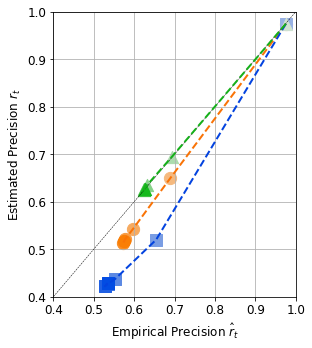

In [9]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize = (4.5,5),tight_layout=True)


i = np.where(kappa_z_array==1)[0][0]
empirical = [ vonMises_stats[i,:,1], GaussADF_stats[i,:,1], PF_stats[i,:,1] ]
estimated = [ vonMises_stats[i,:,2], GaussADF_stats[i,:,2], PF_stats[i,:,2] ]

hue_Gauss = ['#024CE3','#2060E3','#3E74E3','#5C89E3','#7A9DE3','#98B1E3']
hue_Gauss = hue_Gauss[::-1]
hue_vM = ['#FA7E05','#F98D23','#F79B42','#F6AA60','#F5B97E','#F3C79D']
hue_vM = hue_vM[::-1]
hue_PF = ['#15B91C','#3BC140','#60CA64','#86D289','#ABDBAD','#D1E3D1']
hue_PF = hue_PF[::-1]


# scatter plot
ax.plot([0,1],[0,1],'--',linewidth=0.5,color='black')
for i in np.arange(lentime):
    ax.scatter(empirical[0][i],estimated[0][i],c=hue_vM[i],marker='o',s=150,label='von Mises')
    ax.scatter(empirical[1][i],estimated[1][i],c=hue_Gauss[i],marker='s',s=150,label='Gauss')
    ax.scatter(empirical[2][i],estimated[2][i],c=hue_PF[i],marker='^',s=150,label='PF')

ax.plot(empirical[0],estimated[0],'--',c=col_vM,linewidth=2)
ax.plot(empirical[1],estimated[1],'--',c=col_ADF,linewidth=2)
ax.plot(empirical[2],estimated[2],'--',c=col_PF,linewidth=2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0.4,1])
ax.set_xlim([0.4,1])
ax.set_ylabel(r'Estimated Precision $r_t$')
ax.set_xlabel(r'Empirical Precision $\hat{r}_t$')
ax.grid()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10)

plt.savefig('figures/scatterplot_direct.pdf')

plt.show()

## Figure 3c

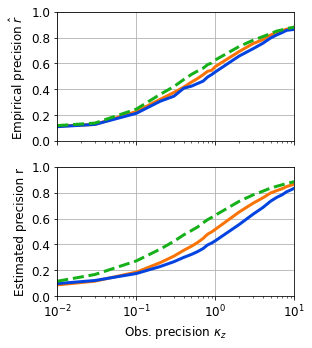

In [10]:
plt.rcParams.update({'font.size': 12})
fig, (ax1,ax2) = plt.subplots(ncols=1,nrows=2,figsize = (4.5,5),sharex=True,tight_layout=True)

# first order statistics
ax1.plot(kappa_z_array,vonMises_stats[:,-1,1],label='Projection Filter',linewidth=3,color=col_vM)
ax1.plot(kappa_z_array,GaussADF_stats[:,-1,1],label='Gauss ADF',linewidth=3,color=col_ADF)
ax1.plot(kappa_z_array,PF_stats[:,-1,1],'--',label='ParticleFilter',linewidth=3,color=col_PF)
ax1.set_ylabel(r'Empirical precision $\hat{r}$')
ax1.set_xscale('log')
ax1.grid()
ax1.set_ylim([0,1])
ax1.set_xlim([kappa_z_array[0],kappa_z_array[-1]])


# second order statistics
ax2.plot(kappa_z_array,vonMises_stats[:,-1,2],label='Projection Filter',linewidth=3,color=col_vM)
ax2.plot(kappa_z_array,GaussADF_stats[:,-1,2],label='Gauss ADF',linewidth=3,color=col_ADF)
ax2.plot(kappa_z_array,PF_stats[:,-1,2],'--',label='ParticleFilter',linewidth=3,color=col_PF)
ax2.set_ylabel('Estimated precision r')
ax2.set_xlabel(r'Obs. precision $\kappa_z$')
ax2.set_ylim([0,1])
ax2.grid()
ax2.set_xlim([kappa_z_array[0],kappa_z_array[-1]])
ax2.set_xscale('log')

plt.show()